# AI FOR SECURITY - PROJECT 2024/2025

## INTRODUCTION

The Internet of Medical Things (IoMT) has become increasingly vital in healthcare, enabling continuous patient monitoring and automated medical services. However, this connectivity also introduces cybersecurity risks that could compromise patient care and privacy. The CICIoMT2024 dataset, developed by the Canadian Institute for Cybersecurity (CIC), provides a comprehensive benchmark for evaluating IoMT security solutions.

### Dataset Overview
- Contains network traffic from 40 IoMT devices (25 real and 15 simulated)
- Includes traffic across multiple protocols: Wi-Fi, MQTT, and Bluetooth
- Features 18 different types of attacks categorized into:
  - DDoS (Distributed Denial of Service)
  - DoS (Denial of Service)
  - Reconnaissance
  - MQTT-specific attacks
  - Spoofing


### Project Objectives
1. Analyze a subset of the CICIoMT2024 dataset to develop efficient security models
2. Implement and evaluate both supervised and unsupervised learning approaches
3. Compare model performance across different attack categories
4. Identify the most effective model for real-time threat detection in IoMT networks

Our analysis will focus on the trade-off between model complexity and detection accuracy, aiming to provide practical insights for securing healthcare IoT infrastructure.

## Libraries

### Data Manipulation and Analysis

In [3]:
import pandas as pd
import numpy as np

### Data Visualisation

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm

### Text Processing

In [5]:
import re

### Machine Learning

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

### Evaluation

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### System/File Operations

In [8]:
import os
from typing import Tuple, Dict, Literal, Optional, List
from collections import defaultdict

## DATASET PREPARATION

### Download Dataset

Create the directory and download the whole CSV dataset through *wget*
```bash
mkdir dataset
cd dataset/ && wget -c -r -np -nH --cut-dirs=3 -R "index.html*" http://205.174.165.80/IOTDataset/CICIoMT2024/Dataset/WiFI_and_MQTT/attacks/CSV/
```

### Analyse Dataset

The dataset consists of network traffic files organized by protocols and different attack types. Due to the diverse distribution of data across files, our first step was to analyze the volume of samples. This initial assessment was crucial as significant imbalances in data volume between attack types or protocols could skew our analysis.

Understanding these distributions allowed us to create a balanced and representative subset of the data for our analysis while ensuring computational efficiency.

#### File Length Analysis

The following code analyzes and visualizes the data distribution across files, implementing our sampling process based on file sizes:

- Files < 20k rows: Retained entirely
- Files 20k-100k rows: Keep 20k rows + 20% of remaining data
- Files > 100k rows: Apply previous rules + 10% of remaining data

This stratified sampling approach helps maintain dataset balance while managing computational resources. The visualization uses color coding (green/orange/red) to highlight these size thresholds.

In [30]:
PLOT_CONFIG = {
    'thresholds': {'small': 20000, 'medium': 100000},
    'colors': {'small': 'green', 'medium': 'orange', 'large': 'red'},
    'base_path': 'dataset'
}

def get_color_by_length(length: int) -> str:
    if length < PLOT_CONFIG['thresholds']['small']:
        return PLOT_CONFIG['colors']['small']
    elif length < PLOT_CONFIG['thresholds']['medium']:
        return PLOT_CONFIG['colors']['medium']
    return PLOT_CONFIG['colors']['large']

def get_directory_path(name: str, directory_type: Literal['original', 'subset']) -> str:
    dir_suffix = "_og" if directory_type == "original" else ""
    return os.path.join(PLOT_CONFIG['base_path'], directory_type, f"{name}{dir_suffix}")

def get_file_lengths(data_dir: str) -> Dict[str, int]:
    return {
        file: len(pd.read_csv(os.path.join(data_dir, file)))
        for file in tqdm(os.listdir(data_dir))
        if file.endswith('.csv')
    }

In [31]:
def plot_len(
    name: str,
    directory_type: Literal['original', 'subset'] = 'original',
    sort_by: Literal['name', 'length'] = 'length',
    ascending: bool = True
) -> None:
    # Get data
    data_dir = get_directory_path(name, directory_type)
    if not os.path.exists(data_dir):
        print(f"Directory not found: {data_dir}")
        return
        
    file_lengths = get_file_lengths(data_dir)
    if not file_lengths:
        print(f"No CSV files found in {data_dir}")
        return

    # Sort data
    sorted_items = sorted(
        file_lengths.items(),
        key=lambda x: x[0] if sort_by == 'name' else x[1],
        reverse=not ascending
    )
    files, lengths = zip(*sorted_items)

    # Create and style plot
    plt.figure(figsize=(15, 8))
    bars = plt.bar(files, lengths)

    if directory_type == "original":
        for bar in bars:
            bar.set_color(get_color_by_length(bar.get_height()))
        
        legend_elements = [
            plt.Rectangle((0,0), 1, 1, facecolor=color, label=f'{label} rows')
            for label, color in [('<20k', 'green'), ('20k-100k', 'orange'), ('>100k', 'red')]
        ]
        plt.legend(handles=legend_elements)

    plt.title(f'Number of Rows in Each CSV File - {name} Dataset ({directory_type})', pad=20)
    plt.xlabel('File Names')
    plt.ylabel('Number of Rows')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save and display
    os.makedirs('img', exist_ok=True)
    plt.savefig(f'img/file_lengths_{name}_{directory_type}.png', bbox_inches='tight')
    plt.show()

100%|██████████| 51/51 [00:20<00:00,  2.54it/s]


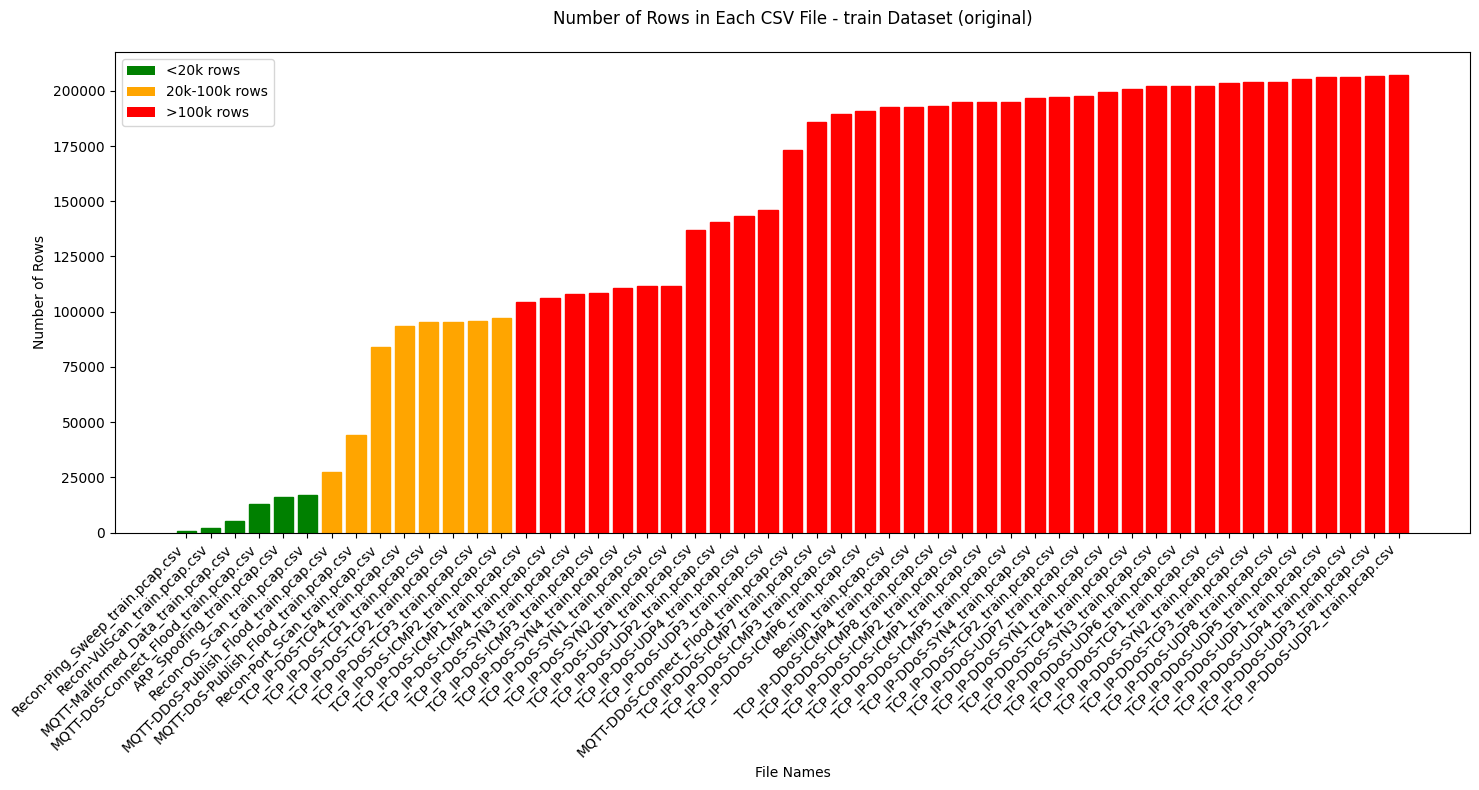

100%|██████████| 21/21 [00:04<00:00,  4.70it/s]


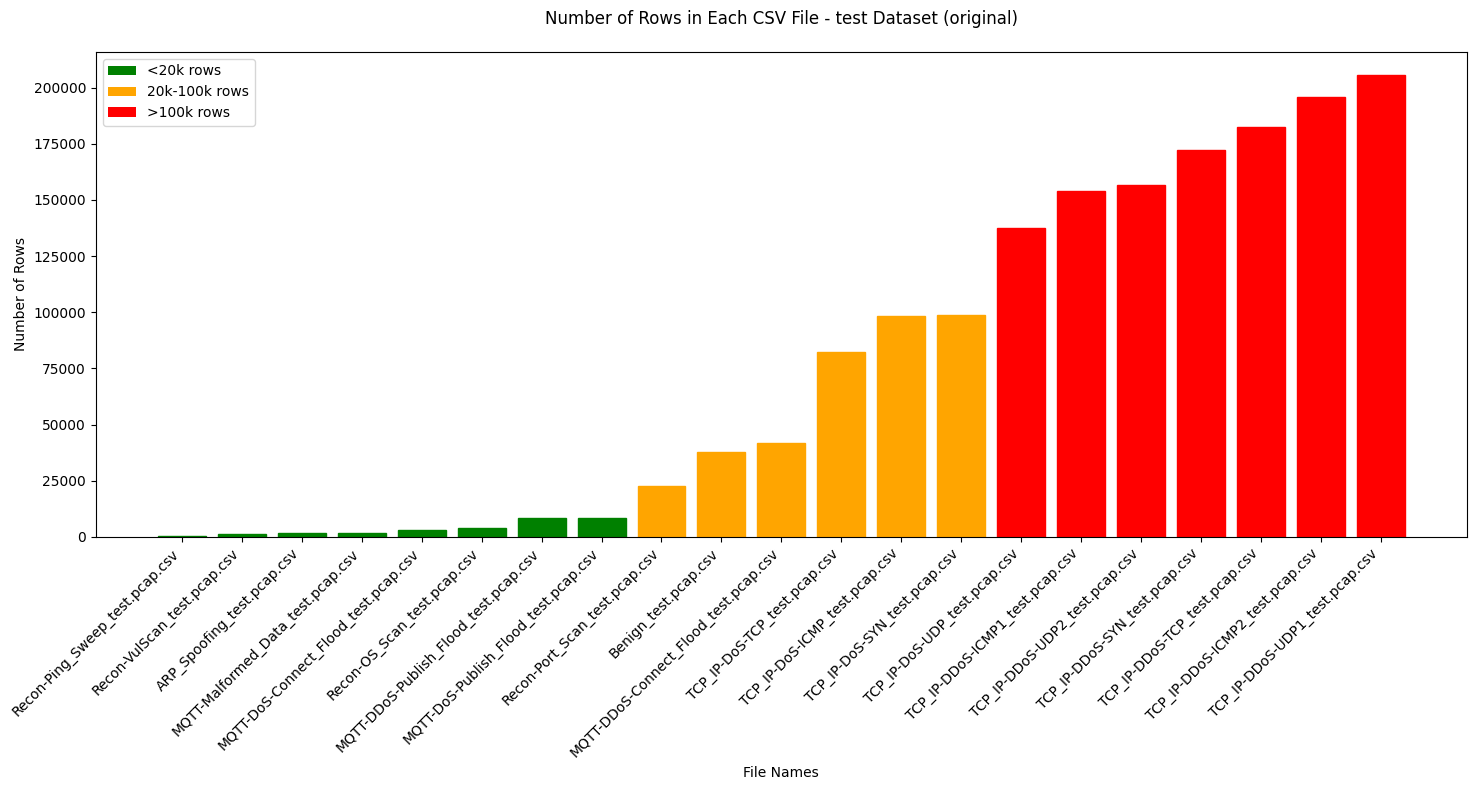

In [32]:
plot_len('train')
plot_len('test')

### Subset

#### Create Directory
```bash
mkdir dataset/subset && cd dataset/subset
mkdir train && mkdir test
```

#### Subset Generation 

This code implements our sampling strategy through random sampling, using a fixed random seed for reproducibility. 

For each file, it applies the rules presented before.
The stratified approach maintains data representativeness while reducing volume, with random sampling ensuring unbiased selection across each range.

In [33]:
SUB_CONFIG = {
    'RANDOM_SEED': 42,
    'CAP': 20000,
    'FIRST': 0.2,
    'SECOND': 0.1,
    'DIRS': {
        'original': 'dataset/original',
        'subset': 'dataset/subset'
    }
}

def calculate_subset(df: pd.DataFrame) -> pd.DataFrame:
    """Create subset based on dataframe size."""
    total_rows = len(df)
    
    if total_rows < SUB_CONFIG['CAP']:
        return df
        
    # Get first 20k random rows
    first = df.sample(n=SUB_CONFIG['CAP'], random_state=SUB_CONFIG['RANDOM_SEED'])
    
    if total_rows < 100000:
        # For files between 20k and 100k
        remaining = df.drop(first.index)
        additional = remaining.sample(frac=SUB_CONFIG['FIRST'], 
                                   random_state=SUB_CONFIG['RANDOM_SEED'])
        return pd.concat([first, additional])
    
    # For files over 100k
    next_80k = df.drop(first.index).sample(
        n=(100000-SUB_CONFIG['CAP']), 
        random_state=SUB_CONFIG['RANDOM_SEED']
    )
    twenty_percent = next_80k.sample(
        frac=0.2, 
        random_state=SUB_CONFIG['RANDOM_SEED']
    )
    
    remaining = df.drop(first.index).drop(next_80k.index)
    ten_percent = remaining.sample(
        frac=0.1, 
        random_state=SUB_CONFIG['RANDOM_SEED']
    )
    
    return pd.concat([first, twenty_percent, ten_percent])

In [34]:
def process_file(file_path: str, output_path: str) -> tuple:
    """Process single file and return statistics."""
    df = pd.read_csv(file_path)
    original_size = len(df)
    df_subset = calculate_subset(df)
    df_subset.to_csv(output_path, index=False)
    
    return original_size, len(df_subset)

def create_subset(name: str) -> None:
    """Create subset for given dataset."""
    np.random.seed(SUB_CONFIG['RANDOM_SEED'])
    
    # Setup directories
    og_dir = os.path.join(SUB_CONFIG['DIRS']['original'], f"{name}_og")
    sub_dir = os.path.join(SUB_CONFIG['DIRS']['subset'], name)
    os.makedirs(sub_dir, exist_ok=True)
    
    print(f"Processing directory: {og_dir}")
    
    # Process files
    for file in tqdm(os.listdir(og_dir), desc="Processing files"):
        if file.endswith('.csv'):
            orig_size, sub_size = process_file(
                os.path.join(og_dir, file),
                os.path.join(sub_dir, file)
            )
            
            # reduction = ((orig_size - sub_size) / orig_size * 100)
    
    print(f"Finished processing {name} directory\n")

In [35]:
create_subset('train')
create_subset('test')

Processing directory: dataset/original/train_og


Processing files: 100%|██████████| 51/51 [01:18<00:00,  1.55s/it]


Finished processing train directory

Processing directory: dataset/original/test_og


Processing files: 100%|██████████| 21/21 [00:19<00:00,  1.09it/s]

Finished processing test directory




Analyzing train dataset...


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


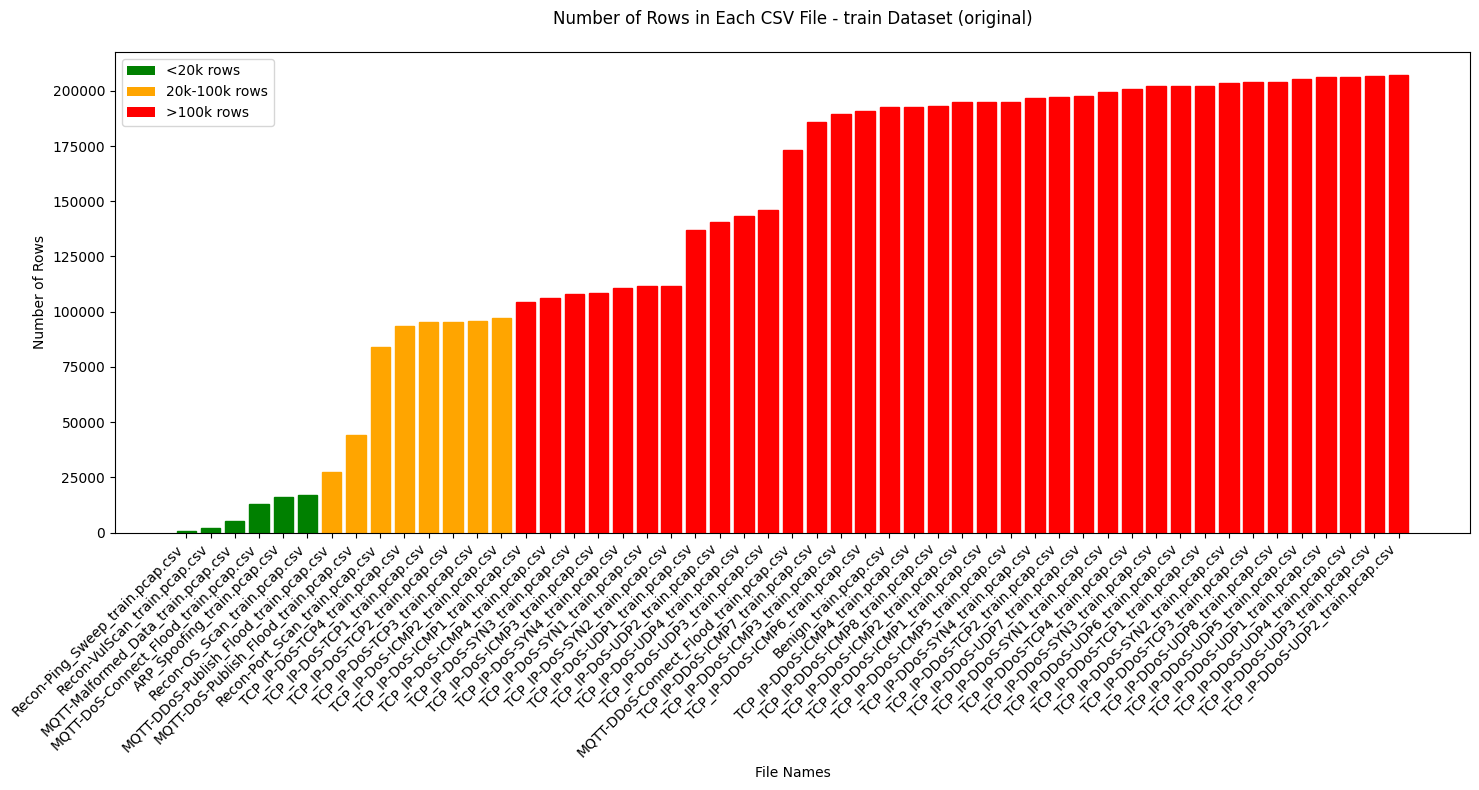

100%|██████████| 51/51 [00:06<00:00,  7.87it/s]


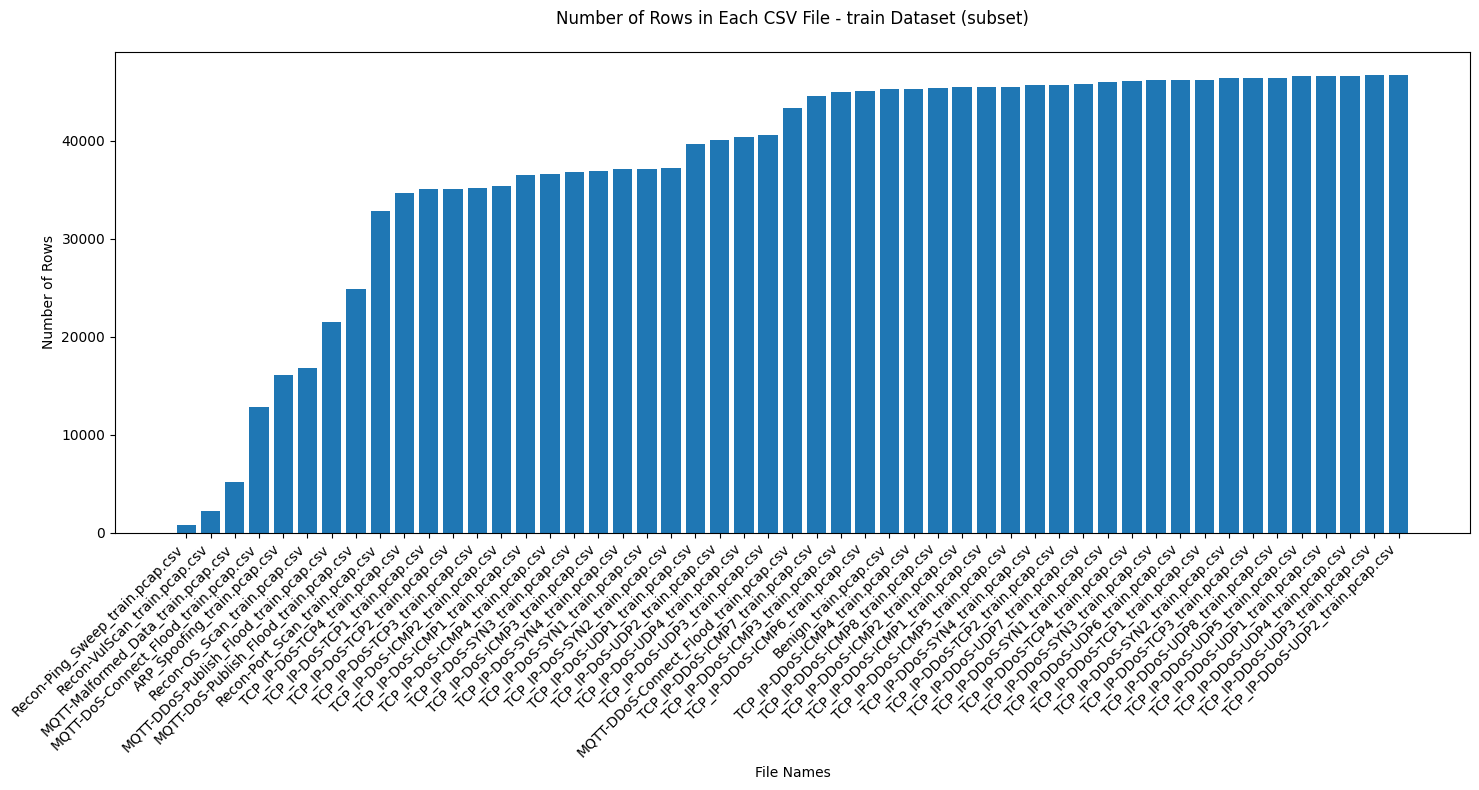


Analyzing test dataset...


100%|██████████| 21/21 [00:05<00:00,  4.00it/s]


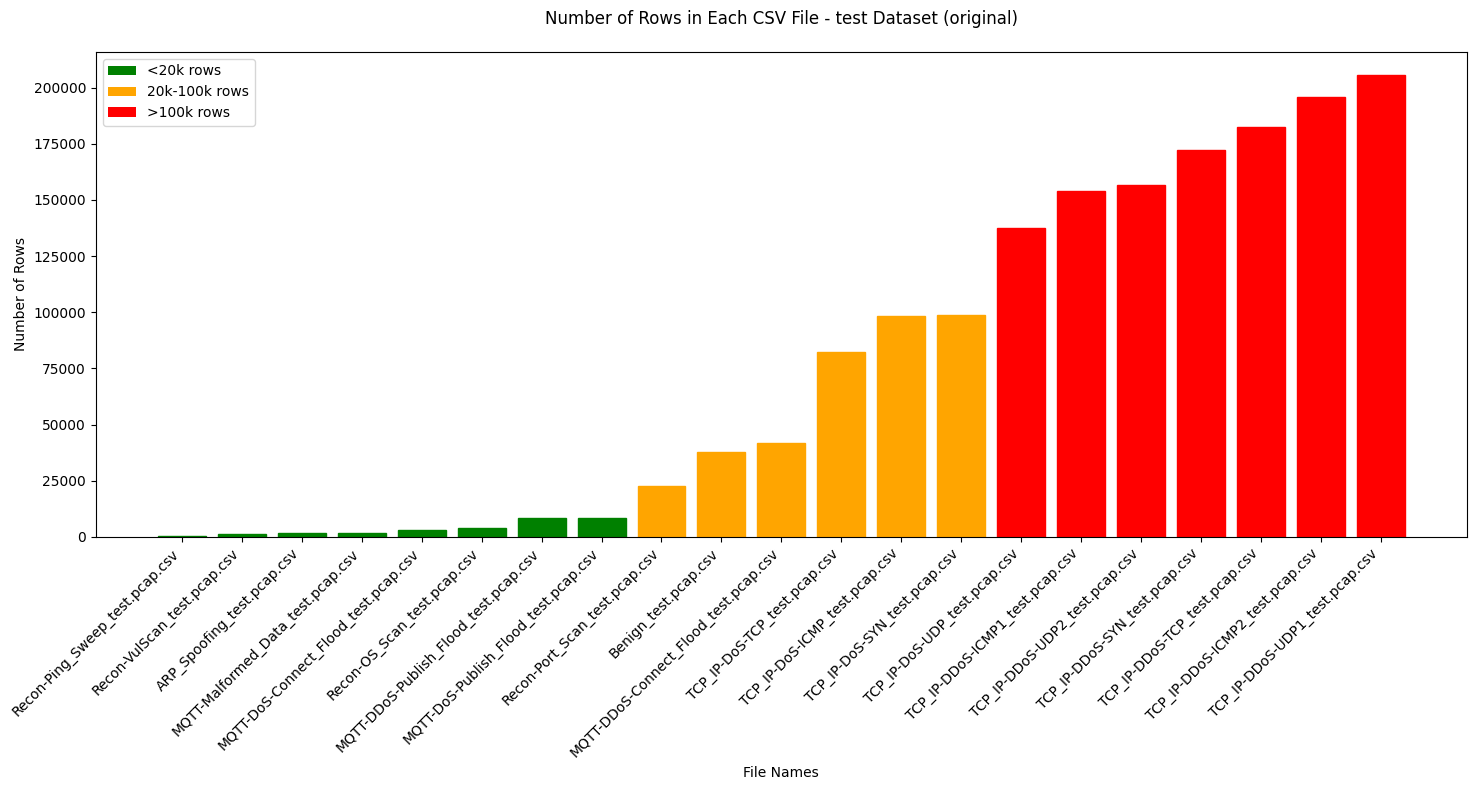

100%|██████████| 21/21 [00:01<00:00, 14.92it/s]


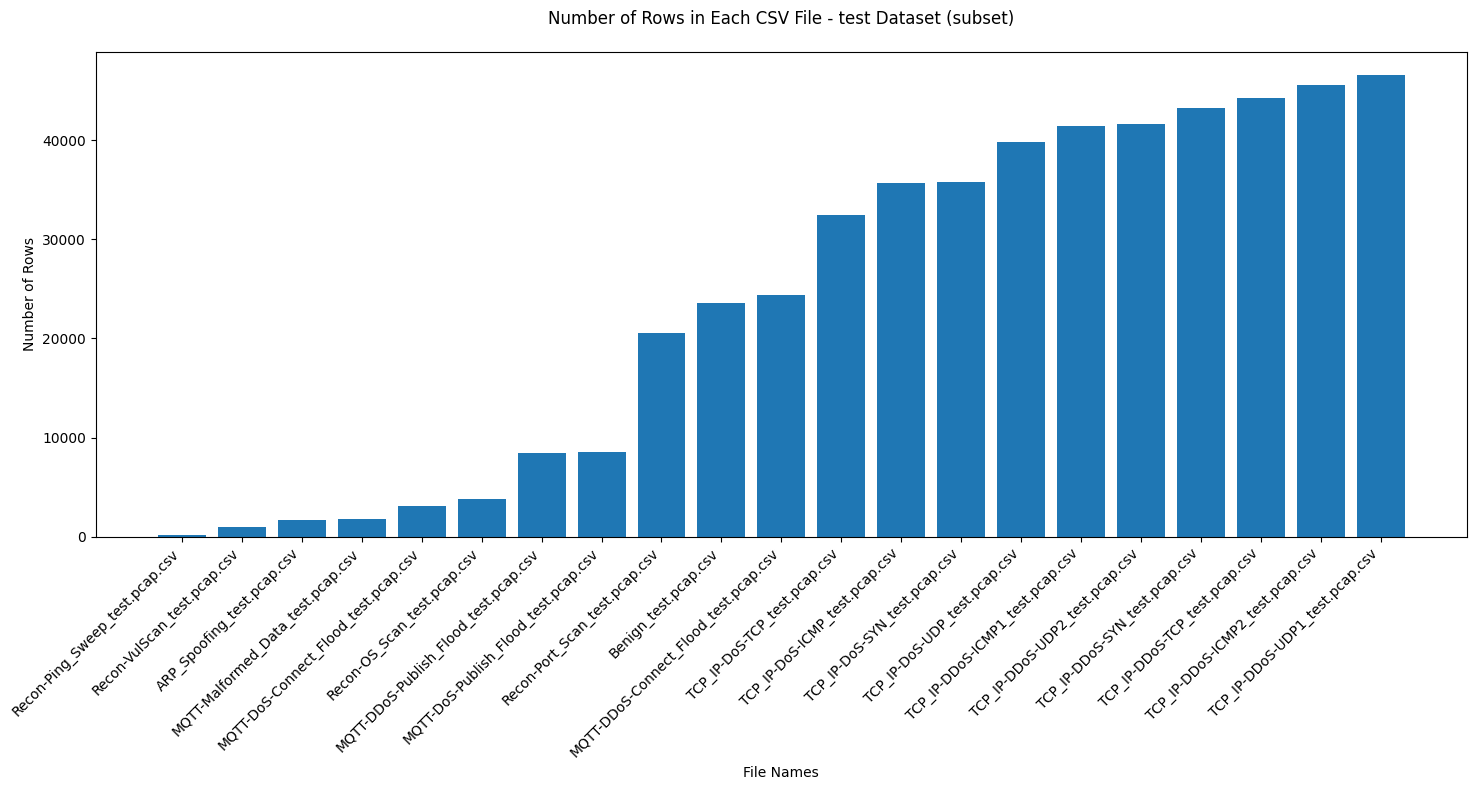

In [36]:
def compare_directories(name: str) -> None:
    print(f"\nAnalyzing {name} dataset...")
    plot_len(name, "original")
    plot_len(name, "subset")
    
# Compare the original and subset directories
compare_directories("train")
compare_directories("test")

### Data Merging and Additional Feature Creation
After creating subsets, we merged the files into consolidated train and test datasets, adding two categorical features:
- `category`: Attack classification (DDoS, DoS, etc.)
- `attack`: Specific attack type 

The mapping between filenames and attack types was automated using regex pattern matching. This consolidation maintains attack classification information while simplifying subsequent analysis.

In [37]:
ATTACK_MAPPING: Dict[str, Tuple[str, str]] = {
    r'^Benign': ('BENIGN', '-'),
    r'^ARP_Spoofing': ('SPOOFING', 'ARP Spoofing'),
    r'^Recon-Ping_Sweep': ('RECON', 'Ping Sweep'),
    r'^Recon-VulScan': ('RECON', 'Recon VulScan'),
    r'^Recon-OS_Scan': ('RECON', 'OS Scan'),
    r'^Recon-Port_Scan': ('RECON', 'Port Scan'),
    r'^MQTT-Malformed_Data': ('MQTT', 'Malformed Data'),
    r'^MQTT-DoS-Connect_Flood': ('MQTT', 'DoS Connect Flood'),
    r'^MQTT-DDoS-Publish_Flood': ('MQTT', 'DDoS Publish Flood'),
    r'^MQTT-DoS-Publish_Flood': ('MQTT', 'DoS Publish Flood'),
    r'^MQTT-DDoS-Connect_Flood': ('MQTT', 'DDoS Connect Flood'),
    r'TCP_IP-DoS-TCP': ('DoS', 'DoS TCP'),
    r'TCP_IP-DoS-ICMP': ('DoS', 'DoS ICMP'),
    r'TCP_IP-DoS-SYN': ('DoS', 'DoS SYN'),
    r'TCP_IP-DoS-UDP': ('DoS', 'DoS UDP'),
    r'TCP_IP-DDoS-SYN': ('DDoS', 'DDoS SYN'),
    r'TCP_IP-DDoS-TCP': ('DDoS', 'DDoS TCP'),
    r'TCP_IP-DDoS-ICMP': ('DDoS', 'DDoS ICMP'),
    r'TCP_IP-DDoS-UDP': ('DDoS', 'DDoS UDP')
}

def get_category_and_attack(filename: str) -> Tuple[str, str]:
    """Get category and attack type from filename."""
    for pattern, (category, attack) in ATTACK_MAPPING.items():
        if re.match(pattern, filename):
            return category, attack
    return 'UNKNOWN', 'UNKNOWN'

def process_file(filepath: str) -> pd.DataFrame:
    """Process single CSV file and add categorization."""
    filename = os.path.basename(filepath)
    category, attack = get_category_and_attack(filename)
    
    df = pd.read_csv(filepath)
    df['category'] = category
    df['attack'] = attack
    
    return df

In [38]:
def merge_csv_files(directory: str, output_file: str) -> pd.DataFrame:
    """Merge CSV files and return merged DataFrame."""
    # Get CSV files
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    print(f"Found {len(files)} CSV files in {directory}")
    
    # Process files
    dfs = []
    for filename in tqdm(files, desc="Processing files"):
        try:
            filepath = os.path.join(directory, filename)
            df = process_file(filepath)
            dfs.append(df)
        except Exception as e:
            print(f"\nError processing {filename}: {str(e)}")
    
    # Merge and save
    print("\nMerging dataframes...")
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(output_file, index=False)
    
    return merged_df

In [39]:
base_dir = 'dataset/subset'

def show_distribution(df: pd.DataFrame) -> None:
   summary = df.groupby(['category', 'attack']).size().reset_index(name='count')
   summary = summary.sort_values('count', ascending=False)
   print(tabulate(summary, headers='keys', tablefmt='psql'))

for dataset in ['train', 'test']:
    mdf = merge_csv_files(os.path.join(base_dir, dataset), f'dataset/merged_{dataset}.csv')
    print(f"\nTotal rows: {len(mdf):,}")
    display(show_distribution(mdf))

Found 51 CSV files in dataset/subset/train


Processing files: 100%|██████████| 51/51 [00:06<00:00,  8.29it/s]



Merging dataframes...

Total rows: 1,917,744
+----+------------+--------------------+---------+
|    | category   | attack             |   count |
|----+------------+--------------------+---------|
|  4 | DDoS       | DDoS UDP           |  371595 |
|  1 | DDoS       | DDoS ICMP          |  361748 |
|  3 | DDoS       | DDoS TCP           |  184447 |
|  2 | DDoS       | DDoS SYN           |  184196 |
|  8 | DoS        | DoS UDP            |  160695 |
|  6 | DoS        | DoS SYN            |  148191 |
|  5 | DoS        | DoS ICMP           |  145327 |
|  7 | DoS        | DoS TCP            |  140077 |
|  0 | BENIGN     | -                  |   45273 |
|  9 | MQTT       | DDoS Connect Flood |   43304 |
| 16 | RECON      | Port Scan          |   32796 |
| 12 | MQTT       | DoS Publish Flood  |   24875 |
| 10 | MQTT       | DDoS Publish Flood |   21525 |
| 14 | RECON      | OS Scan            |   16832 |
| 18 | SPOOFING   | ARP Spoofing       |   16047 |
| 11 | MQTT       | DoS Connect Floo

None

Found 21 CSV files in dataset/subset/test


Processing files: 100%|██████████| 21/21 [00:01<00:00, 11.58it/s]



Merging dataframes...

Total rows: 503,281
+----+------------+--------------------+---------+
|    | category   | attack             |   count |
|----+------------+--------------------+---------|
|  4 | DDoS       | DDoS UDP           |   88207 |
|  1 | DDoS       | DDoS ICMP          |   86970 |
|  3 | DDoS       | DDoS TCP           |   44260 |
|  2 | DDoS       | DDoS SYN           |   43240 |
|  8 | DoS        | DoS UDP            |   39755 |
|  6 | DoS        | DoS SYN            |   35719 |
|  5 | DoS        | DoS ICMP           |   35686 |
|  7 | DoS        | DoS TCP            |   32419 |
|  9 | MQTT       | DDoS Connect Flood |   24383 |
|  0 | BENIGN     | -                  |   23521 |
| 16 | RECON      | Port Scan          |   20524 |
| 12 | MQTT       | DoS Publish Flood  |    8505 |
| 10 | MQTT       | DDoS Publish Flood |    8416 |
| 14 | RECON      | OS Scan            |    3834 |
| 11 | MQTT       | DoS Connect Flood  |    3131 |
| 13 | MQTT       | Malformed Data    

None

## ANALYSING FEATURES

In [9]:
# Load the merged dataset
df = pd.read_csv('dataset/merged_train.csv')

In [15]:
# Pinrt some basic information
print(tabulate(pd.DataFrame({'Type': df.dtypes}), headers='keys', tablefmt='psql'))

+-----------------+---------+
|                 | Type    |
|-----------------+---------|
| Header_Length   | float64 |
| Protocol Type   | float64 |
| Duration        | float64 |
| Rate            | float64 |
| Srate           | float64 |
| Drate           | float64 |
| fin_flag_number | float64 |
| syn_flag_number | float64 |
| rst_flag_number | float64 |
| psh_flag_number | float64 |
| ack_flag_number | float64 |
| ece_flag_number | float64 |
| cwr_flag_number | float64 |
| ack_count       | float64 |
| syn_count       | float64 |
| fin_count       | float64 |
| rst_count       | float64 |
| HTTP            | float64 |
| HTTPS           | float64 |
| DNS             | float64 |
| Telnet          | float64 |
| SMTP            | float64 |
| SSH             | float64 |
| IRC             | float64 |
| TCP             | float64 |
| UDP             | float64 |
| DHCP            | float64 |
| ARP             | float64 |
| ICMP            | float64 |
| IGMP            | float64 |
| IPv     

We can se that each feature is numeric, except for those we created to represent attack type and category

### Statistical Analysis

The following code performs statistical analysis on the merged dataset to uncover feature relationships and characteristics. Through correlation matrices, variance metrics, and zero/missing value analysis, it reveals redundant features and quality issues that inform feature selection and preprocessing decisions.

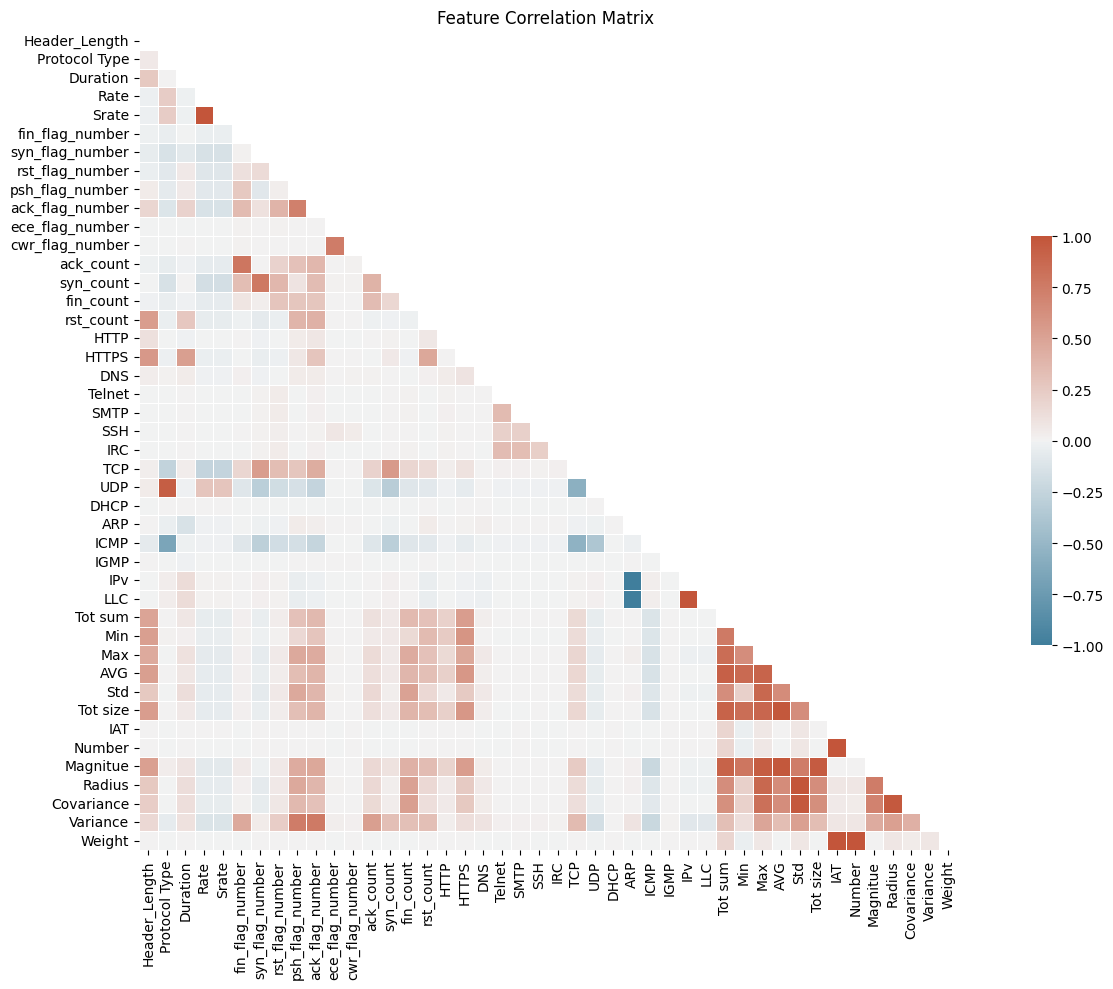


--- Top 10 High Variance Features ---
+---------------+--------------------+
| Feature       |           Variance |
+===============+====================+
| IAT           | 446844238910123.12 |
+---------------+--------------------+
| Header_Length |    174006034183.63 |
+---------------+--------------------+
| Rate          |      1429893748.19 |
+---------------+--------------------+
| Srate         |      1429893748.19 |
+---------------+--------------------+
| Covariance    |       898078009.60 |
+---------------+--------------------+
| Tot sum       |         1770394.19 |
+---------------+--------------------+
| rst_count     |          297672.03 |
+---------------+--------------------+
| Max           |           34281.01 |
+---------------+--------------------+
| AVG           |           14140.92 |
+---------------+--------------------+
| Tot size      |           14069.91 |
+---------------+--------------------+

--- Features with >90% correlation ---
+---------------+-------

In [62]:
def analyze_features(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    # Correlation Analysis
    corr = df.corr(method = 'pearson')
    
    # Feature Variance
    variance = df.var().sort_values(ascending=False)
    
    # Zero Values Percentage
    zero_percent = (df == 0).sum() / len(df) * 100
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           xticklabels=True, yticklabels=True)
    plt.title('Feature Correlation Matrix ')
    plt.tight_layout()
    plt.savefig('img/correlation.png', bbox_inches='tight')
    plt.show()
    
    # Return analysis results
    analysis = {
        'correlation': corr,
        'variance': variance,
        'zero_percentage': zero_percent,
    }
    return analysis

def print_results(analysis_results)-> None:
    # Print variance
    print("\n--- Top 10 High Variance Features ---")
    variance_data = [[feature, value] for feature, value in 
                    analysis_results['variance'].head(10).items()]
    print(tabulate(variance_data, 
                headers=["Feature", "Variance"], 
                tablefmt="grid",
                floatfmt=".2f"))

    # Print correlations
    print("\n--- Features with >90% correlation ---")
    corr_matrix = analysis_results['correlation']
    high_corr = np.where(np.abs(corr_matrix) >= 0.9)
    high_corr_data = []
    for i, j in zip(*high_corr):
        if i < j:  # avoid duplicate pairs
            high_corr_data.append([
                corr_matrix.index[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ])
    print(tabulate(high_corr_data, 
                headers=["Feature 1", "Feature 2", "Correlation"], 
                tablefmt="grid",
                floatfmt=".3f"))

    # Print features with high zero percentage
    print("\n--- Top 10 Zero Value Percentages ---")
    zero_data = [[feature, value] for feature, value in 
                analysis_results['zero_percentage'].sort_values(ascending=False).head(10).items()]
    print(tabulate(zero_data, 
                headers=["Feature", "Zero %"], 
                tablefmt="grid",
                floatfmt=".2f"))

numeric_df = df.select_dtypes(include=[np.number])
analysis_results = analyze_features(numeric_df)
print_results(analysis_results)

## FEATURES SELECTION

We can see, both from the correlation matrix and from the percentages of zero values, that Drate column is emphty: we dropped it.

In [43]:
df=df.drop('Drate', axis=1)

This was the only trivial choice. However, further selection is needed: we can see that there's high correlation within our data, and this can hurt the quality of our models. For this reason, we want to keep only non-redundant feature to maximise the discriminatory power of our variables. 

We based our first approach on the simple observation of the output of the previous analysis. Through a combination of correlation and variance, we decided to drop the following columns: 

In [44]:
to_drop = ["Srate", "Protocol Type", "IPv", "LLC", "Tot sum", "Tot size", "AVG", "Max", "Number", "Weight"]
df_sel_manual = df.drop(columns=to_drop)

To begin evaluating our dataset and choices, we setup a first Classification model. We want to predict if a packet flow is benign or malicious using a Random Forest. For this, we created a new boolean column 'is_benign'. Since we have an abundance of data, we splitted the training dataset into Train and Validation sets, to avoid overfitting the test dataset in this feature selection phase.

In [45]:
# Creating a new boolean column 'is_benign'
df_sel_manual['is_benign'] = df['category'].apply(lambda x: 1 if x == 'BENIGN' else 0)

# Splitting the Dataset in Training and Validation sets
X_train, X_val, y_train, y_val = train_test_split(
    df_sel_manual.drop(['is_benign', 'category', 'attack'], axis=1),
    df_sel_manual['is_benign'], train_size=0.7
)

# Training the RandomForest
rnd_forest = RandomForestClassifier(random_state=42)
rnd_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

A useful metric that the RandomForest ensemble provides, is the Feature Importance (Gini index). This can be used for further refinement of our feature selection.

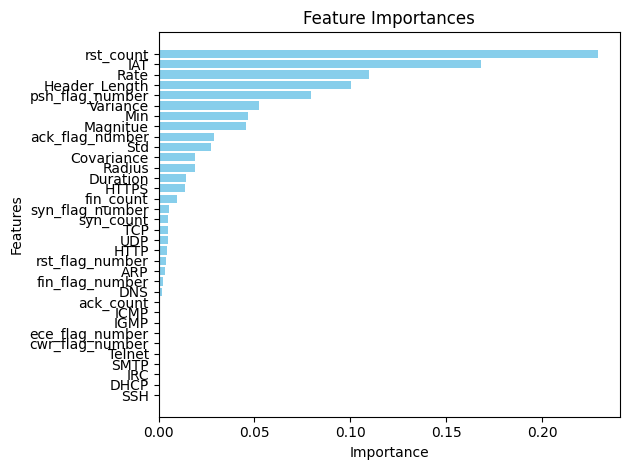

In [46]:
feature_importances_dict = dict(zip(X_train.columns, rnd_forest.feature_importances_))

# Sort features by importance
sorted_dict = dict(sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=False))

# Create plot
#plt.figure(figsize=(8,8))
plt.barh([*sorted_dict.keys()], sorted_dict.values(), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

Evaluating the performance on the validation set, using common metrics:

In [47]:
y_pred = rnd_forest.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy:        {accuracy:.5f}")
print(f"Precision:       {precision:.5f}")
print(f"Recall:          {recall:.5f}")
print(f"F1:              {f1:.5f}")

Accuracy:        0.99857
Precision:       0.97398
Recall:          0.96537
F1:              0.96965


The results are good, but let's try now selecting our features with an approach more robust and reliable. This time, over the correlation calculation (same as before), we compute a Hierarchical Clustering, to group the features more correlated between each others. We selected euclidean distance and complete linkage.

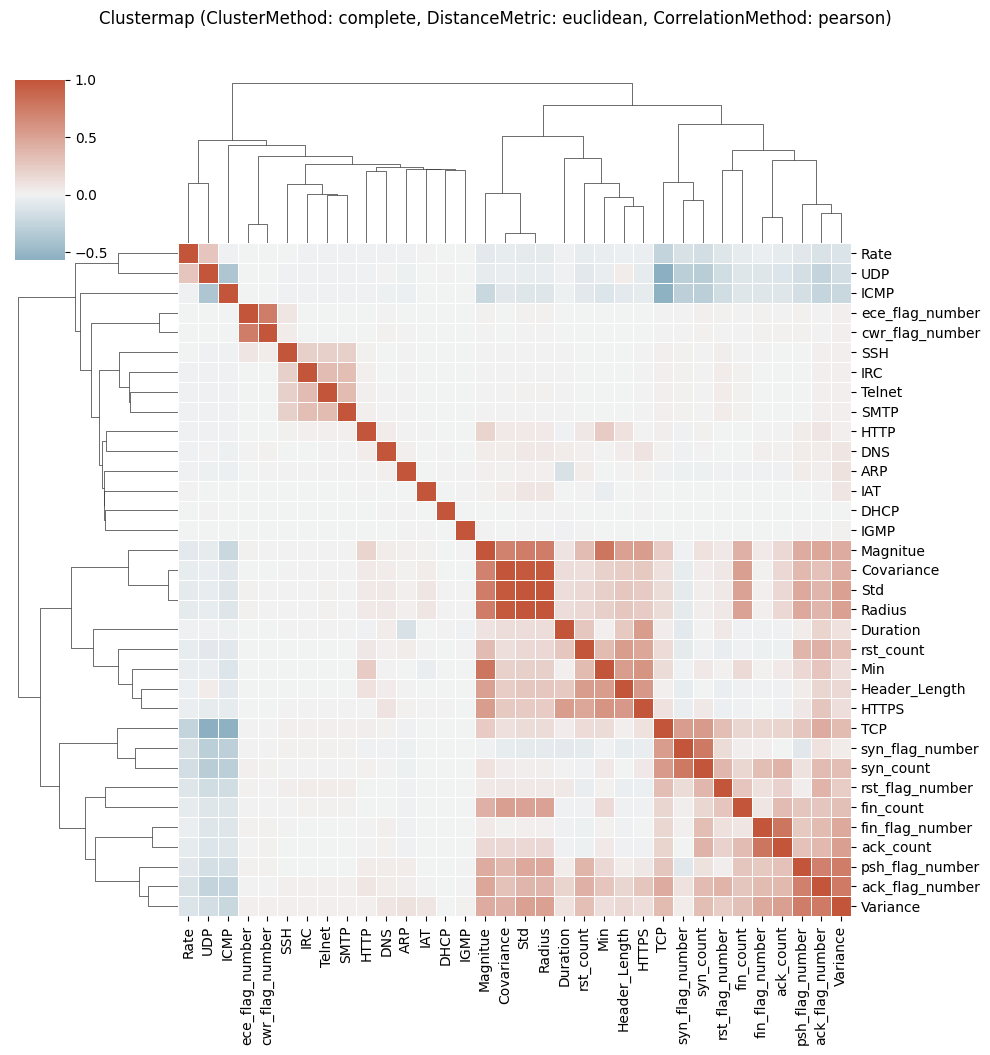

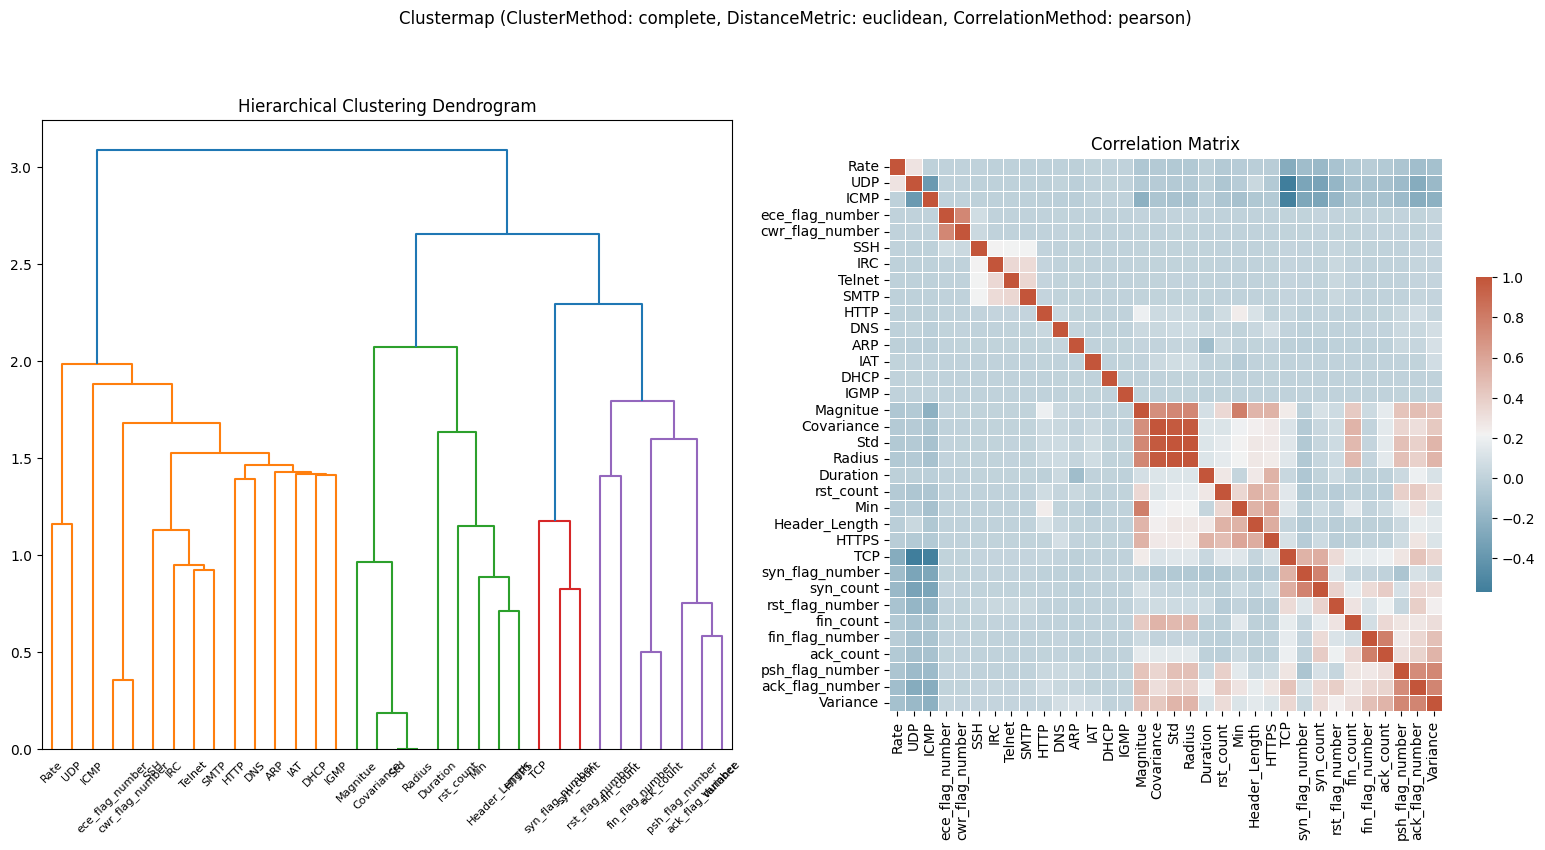

In [55]:
# Parameters
corr_method = 'pearson'
link_method = 'complete'
dist_metric = 'euclidean'

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Compute the correlation matrix (Pearson)
corr = df_sel_manual.drop(['is_benign', 'attack', 'category'], axis=1).corr(method=corr_method)

# Create the clustermap (but we will not display it directly)
g = sns.clustermap(corr, annot=False, cbar=True, cmap=cmap, center=0,
                   linewidths=.5, cbar_kws={"shrink": .5},
                   metric=dist_metric, method=link_method, xticklabels=True, yticklabels=True)
g.fig.suptitle(f"Clustermap (ClusterMethod: {link_method}, DistanceMetric: {dist_metric}, CorrelationMethod: {corr_method})", y=1.05)
plt.show()

# Extract the linkage matrix for the dendrogram
linkage_matrix = g.dendrogram_col.linkage

# Create a figure with two subplots: one for the dendrogram, one for the correlation matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot the dendrogram (left plot)
dendrogram(linkage_matrix, ax=ax1, labels=corr.columns)
ax1.set_title("Hierarchical Clustering Dendrogram")

# Reorder the correlation matrix based on the dendrogram leaf order
dendro_idx = g.dendrogram_col.reordered_ind
reordered_corr = corr.iloc[dendro_idx, dendro_idx]

# Plot the reordered correlation matrix (right plot)
sns.heatmap(reordered_corr, annot=False, cmap=cmap, cbar=True, ax=ax2, cbar_kws={"shrink": .5}, 
            linewidths=0.5, square=True, xticklabels=True, yticklabels=True)
ax2.set_title("Correlation Matrix")

# Add a title for the entire figure
fig.suptitle(f"Clustermap (ClusterMethod: {link_method}, DistanceMetric: {dist_metric}, CorrelationMethod: {corr_method})", y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()

Our decision here is limited in choosing which distance threshold to pick by visually inpecting the dendrogram. The rest in done automatically by the script that selects the feature with the highest importance (Gini), one for each of the clusters resulting by the decided threshold.

In [56]:
# Set a threshold for the clustering
threshold = 1  # Adjust this value based on visual inspection of the dendrogram

# Cut the dendrogram at the chosen threshold to form clusters
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

# Let's group the features by their cluster assignment
clustered_features = {}
for idx, cluster in enumerate(clusters):
    if cluster not in clustered_features:
        clustered_features[cluster] = []
    clustered_features[cluster].append(corr.columns[idx])

# Print features for each cluster
print("Clustered features:")
for cluster, features in clustered_features.items():
    print(f"Cluster {cluster}: {features}")

# Train a RandomForest from the original dataset
X_train, X_val, y_train, y_val = train_test_split(df_sel_manual.drop(['is_benign', 'category', 'attack'], axis=1), df_sel_manual['is_benign'], train_size=0.7)
rnd_forest = RandomForestClassifier(random_state=42)
rnd_forest.fit(X_train, y_train)
# Extract feature importances
feature_importances = rnd_forest.feature_importances_
# Create a dictionary of feature importances
feature_importance_dict = dict(zip(X_train.columns, feature_importances))
# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Select the most important feature from each cluster based on feature importance
selected_features = []
for cluster, features in clustered_features.items():
    # Get the importance of each feature in the cluster
    cluster_importances = {feature: feature_importance_dict[feature] for feature in features}
    
    # Select the feature with the highest importance in the cluster
    best_feature = max(cluster_importances, key=cluster_importances.get)
    selected_features.append(best_feature)

# Print the selected features
print("\nSelected features for each cluster:")
for feature in selected_features:
    print(feature)

Clustered features:
Cluster 14: ['Header_Length', 'HTTPS', 'Min']
Cluster 16: ['Duration']
Cluster 1: ['Rate']
Cluster 21: ['fin_flag_number', 'ack_count']
Cluster 17: ['syn_flag_number', 'syn_count']
Cluster 19: ['rst_flag_number']
Cluster 22: ['psh_flag_number', 'ack_flag_number', 'Variance']
Cluster 3: ['ece_flag_number', 'cwr_flag_number']
Cluster 20: ['fin_count']
Cluster 15: ['rst_count']
Cluster 6: ['HTTP']
Cluster 7: ['DNS']
Cluster 4: ['Telnet', 'SMTP', 'IRC']
Cluster 5: ['SSH']
Cluster 18: ['TCP']
Cluster 2: ['UDP']
Cluster 8: ['DHCP']
Cluster 11: ['ARP']
Cluster 12: ['ICMP']
Cluster 9: ['IGMP']
Cluster 13: ['Std', 'Magnitue', 'Radius', 'Covariance']
Cluster 10: ['IAT']

Selected features for each cluster:
Header_Length
Duration
Rate
ack_count
syn_count
rst_flag_number
psh_flag_number
ece_flag_number
fin_count
rst_count
HTTP
DNS
Telnet
SSH
TCP
UDP
DHCP
ARP
ICMP
IGMP
Magnitue
IAT


In [58]:
selected_features.extend(['is_benign', 'attack', 'category'])
df_sel_hclust = df_sel_manual[selected_features]

Let's train a new RandomForest with the dataset containing the selected features

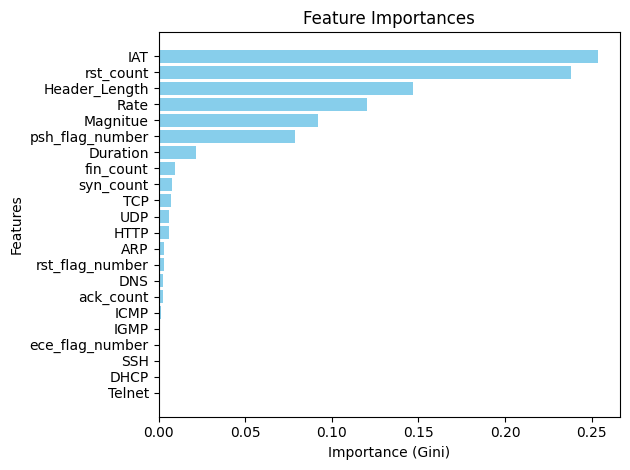

In [59]:
X_train, X_val, y_train, y_val = train_test_split(df_sel_hclust.drop(['is_benign', 'category', 'attack'], axis=1),
                                                  df_sel_hclust['is_benign'], train_size=0.7
                                                 )
rnd_forest.fit(X_train, y_train)
feature_importances_dict = dict(zip(X_train.columns, rnd_forest.feature_importances_))

# Sort features by importance
sorted_dict = dict(sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=False))

# Create plot
#plt.figure(figsize=(8,8))
plt.barh([*sorted_dict.keys()], sorted_dict.values(), color='skyblue')
plt.xlabel('Importance (Gini)')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

Let's test the performance of the new approach we used for feature selection

In [61]:
y_pred = rnd_forest.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print(f"Accuracy:        {accuracy:.5f}")
print(f"Precision:       {precision:.5f}")
print(f"Recall:          {recall:.5f}")
print(f"F1:              {f1:.5f}")

Accuracy:        0.99857
Precision:       0.97593
Recall:          0.96250
F1:              0.96917


There was an improvement!